# Residual Analysis

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, accuracy_score, mean_squared_log_error

import lime
import lime.lime_tabular

from sklearn.pipeline import make_pipeline
from utils.common_transformers import ColumnSelector,DateHandler,IsNull,DTypeTransformer




In [14]:
data_prepping = make_pipeline(
    ColumnSelector(["client_agent","date","purchased","added_in_cart","checked_out"]),
    DateHandler(["date"],date_format="%Y-%m-%d",include=["quater","is_holiday","close_to_month_start_end","month"]),
    IsNull(include=["client_agent"]),
)

## Continous Target

In [15]:
df = pd.read_csv("../data/Train.csv")

X = df.drop("time_spent",axis=1)
y = df["time_spent"]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

X_train = data_prepping.fit_transform(X_train)
X_train["y"] = y_train
X_train = X_train.query("date_month!=9")
y_train = X_train["y"]
X_train.drop("y",axis=1,inplace=True)

model = RandomForestRegressor()
model.fit(X_train,y_train)

RandomForestRegressor()

In [17]:
X_test = data_prepping.transform(X_test)
y_pred = model.predict(X_test)
print(r2_score(y_test,y_pred))
print(np.sqrt(mean_squared_log_error(y_test,y_pred)))

0.07769278058964135
1.8176129306130988


In [18]:
res = X_test.copy()
res["residual"] = y_test - y_pred  

In [19]:
res.dtypes

date_quater                        int64
added_in_cart                      int64
date_month                         int64
purchased                          int64
checked_out                        int64
date_close_to_month_start_end       bool
date_is_holiday                     bool
client_agent_is_null                bool
residual                         float64
dtype: object

In [20]:
res = DTypeTransformer({"checked_out":"bool","added_in_cart":"bool","purchased":"bool","date_quater":"category"}).fit_transform(res)

In [21]:
num_cols = list(set(res.select_dtypes(include=np.number).columns) - set(["residual"]))
cat_cols = res.select_dtypes(include=["category",bool]).columns

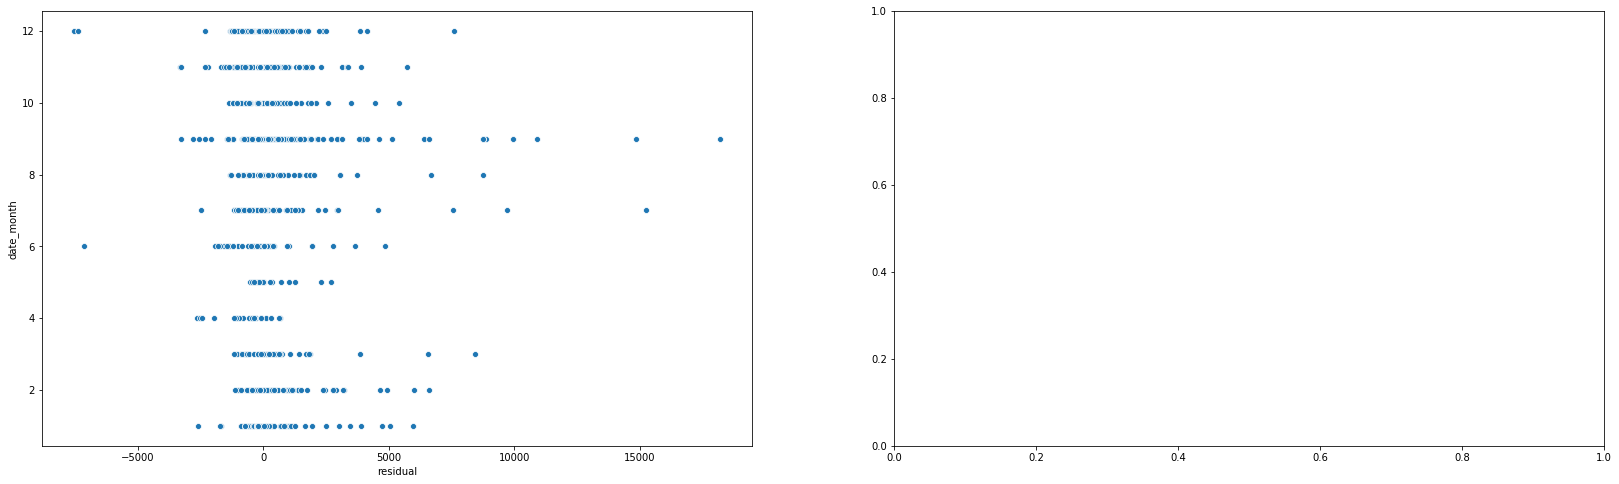

In [22]:
num_rows = int(np.ceil(len(num_cols) / 2))

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(28,num_rows*8))
ax= axes.flatten()
for index,col in enumerate(num_cols,0):
    axes = ax[index]
    sns.scatterplot(res["residual"],res[col],ax=axes)

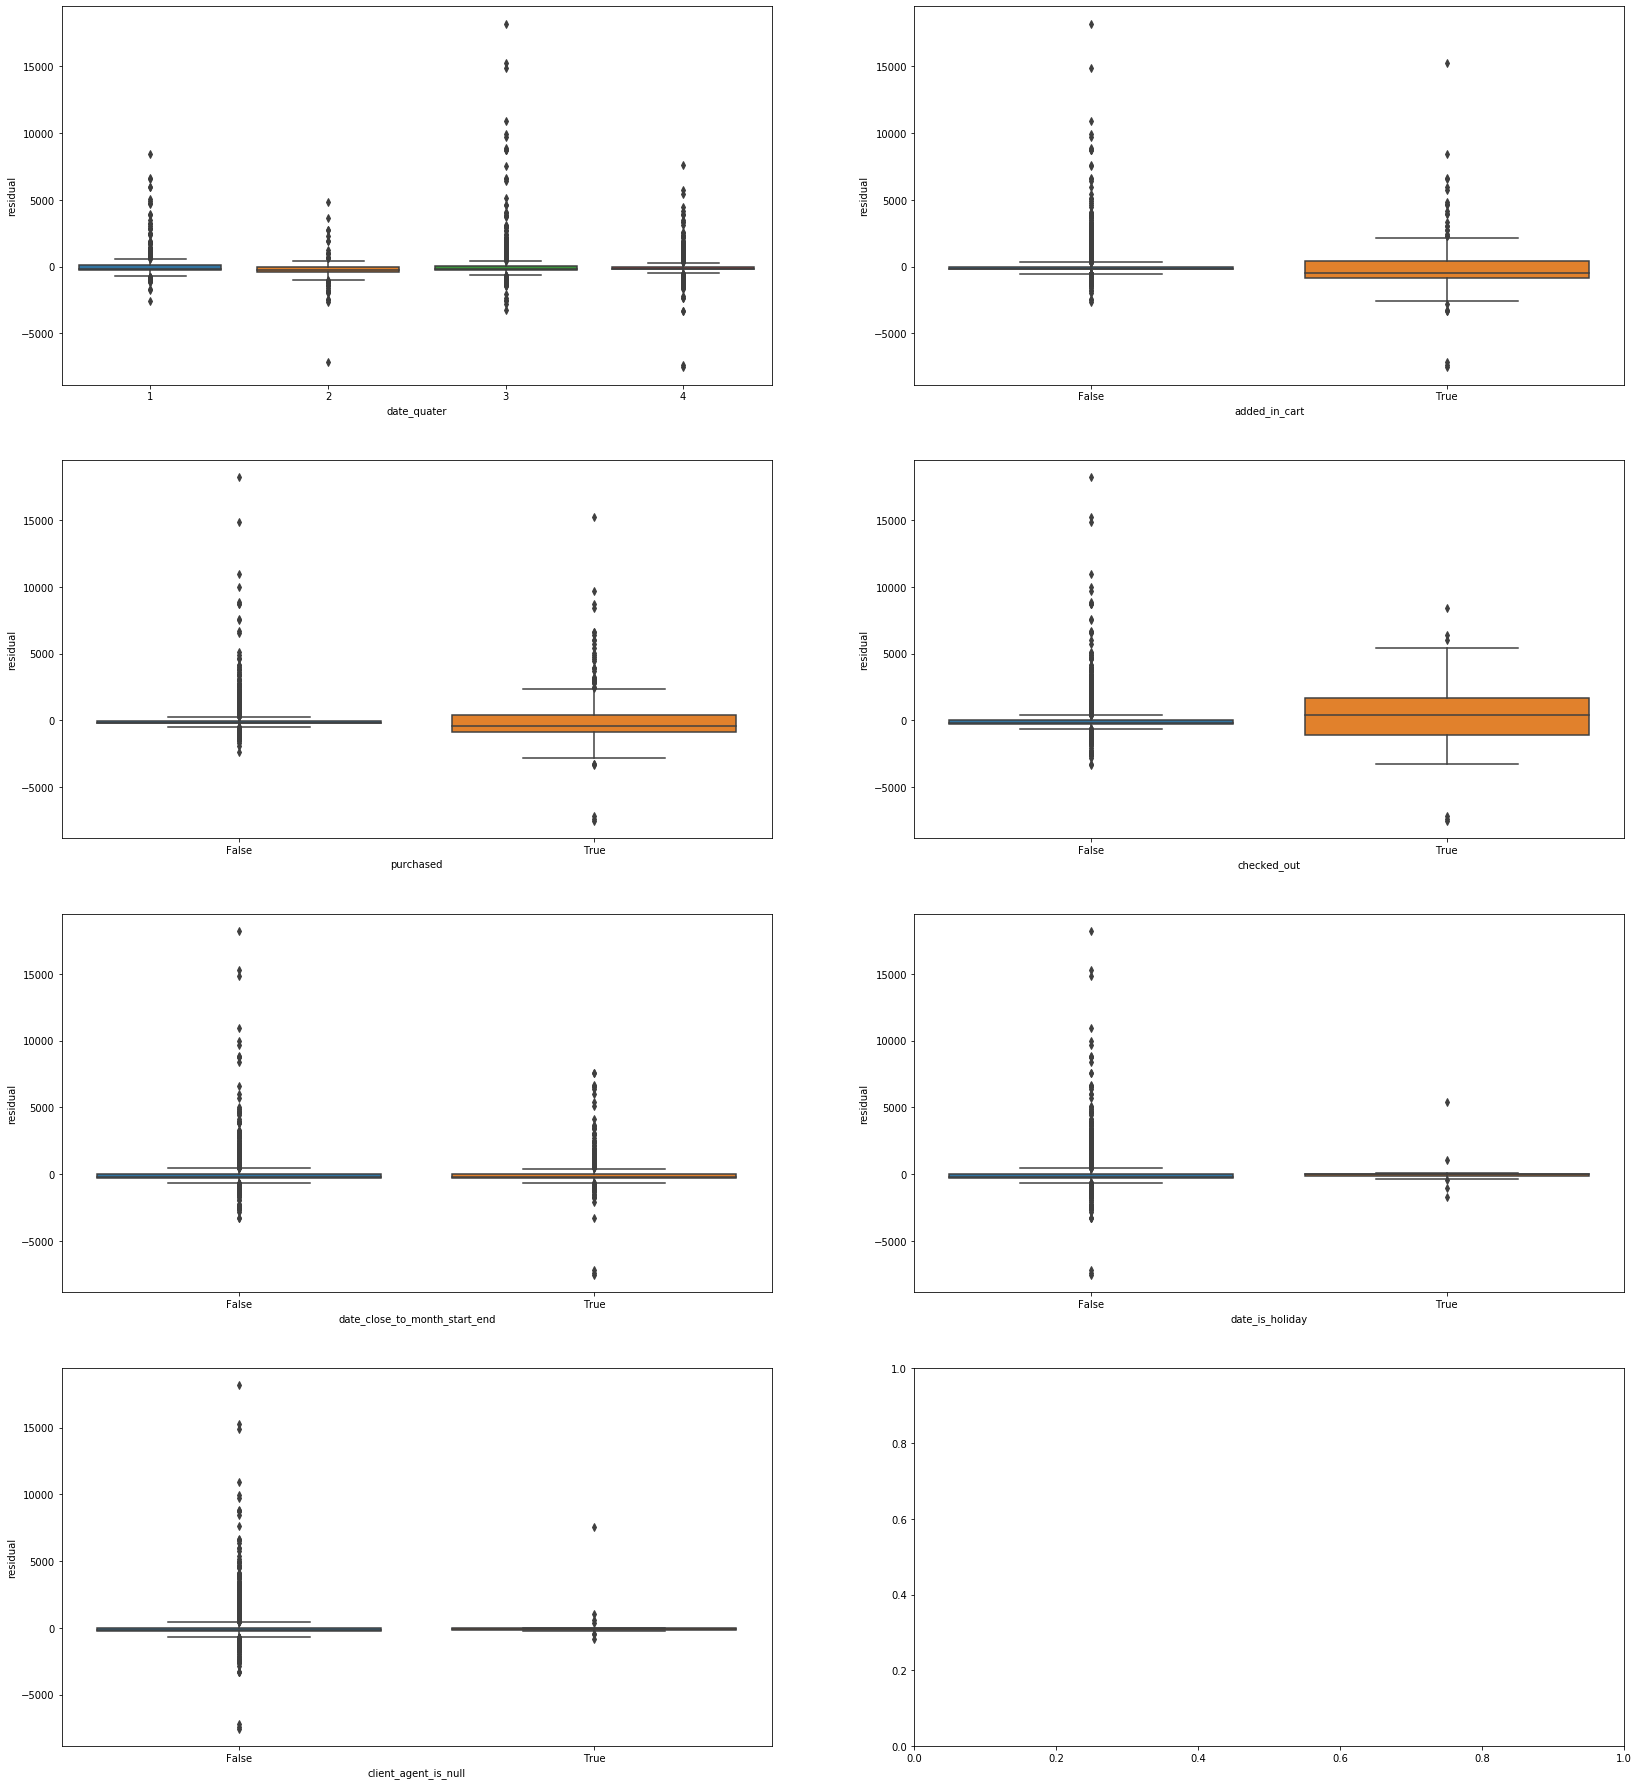

In [23]:
num_rows = int(np.ceil(len(cat_cols) / 2))

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(28,num_rows*8))
ax= axes.flatten()
for index,col in enumerate(cat_cols,0):
    axes = ax[index]
    sns.boxplot(res[col],res["residual"],ax=axes)

## For discrete target

In [24]:
df = sns.load_dataset("titanic")
df = df.dropna()

df = df[["age","who","fare","pclass","survived"]]
df["is_male"] = df["who"].map(lambda x: 1 if x=="man" else 0)

df = df.drop("who",axis=1)
df["pclass"] = pd.Categorical(df["pclass"])
df["is_male"] = pd.Categorical(df["is_male"])
df["survived"] = pd.Categorical(df["survived"])

In [25]:
X = df.drop("survived",axis=1)
y = df["survived"]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4)

In [26]:
model = RandomForestClassifier()
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

print(accuracy_score(y_test,y_pred))
print(model.classes_)

0.7123287671232876
[0 1]


In [27]:
df = X_test.copy()
df["target"] = y_test
df["pred"] = pd.Categorical(y_pred)
df["prob_0"] = y_pred_prob[:,0]
df["prob_1"] = y_pred_prob[:,1]

mis_classified = df.query("target!=pred")

print(df.shape)
print(mis_classified.shape)

(73, 8)
(21, 8)


In [28]:
mis_classified.head()

,age,fare,pclass,is_male,target,pred,prob_0,prob_1
690,31.0,57.0000,1,1,1,0,0.53,0.47
484,25.0,91.0792,1,1,1,0,0.57,0.43
599,49.0,56.9292,1,1,1,0,0.72,0.28
456,65.0,26.5500,1,1,0,1,0.47,0.53
332,38.0,153.4625,1,1,0,1,0.37,0.63


In [29]:
with pd.option_context('mode.chained_assignment', None):
    mis_classified.loc[:,"residual"] = (mis_classified["prob_0"] - mis_classified["prob_1"]).copy()

    num_cols = list(set(mis_classified.select_dtypes(include=np.number).columns) - set(["prob_0","prob_1","residual"]))
    cat_cols = list(set(mis_classified.select_dtypes(include="category").columns) - set(["pred"]))

## Residual Analysis

In [32]:
subset = df[
    ((df["target"]==1) & (df["pred"]==0) & (df["prob_0"]>0.8)) |
    ((df["target"]==0) & (df["pred"]==1) & (df["prob_1"]>0.8))
].copy()

print("Wrongly Predicted 0 with high confidence")
display(subset.query("pred==0"))

print("Wrongly Predicted 1 with high confidence")
display(subset.query("pred==1"))

Wrongly Predicted 0 with high confidence


,age,fare,pclass,is_male,target,pred,prob_0,prob_1
429,32.0,8.0500,3,1,1,0,0.90,0.10
97,23.0,63.3583,1,1,1,0,0.81,0.19


Wrongly Predicted 1 with high confidence


,age,fare,pclass,is_male,target,pred,prob_0,prob_1
544,50.0,106.4250,1,1,0,1,0.18,0.82
498,25.0,151.5500,1,0,0,1,0.10,0.90
698,49.0,110.8833,1,1,0,1,0.16,0.84


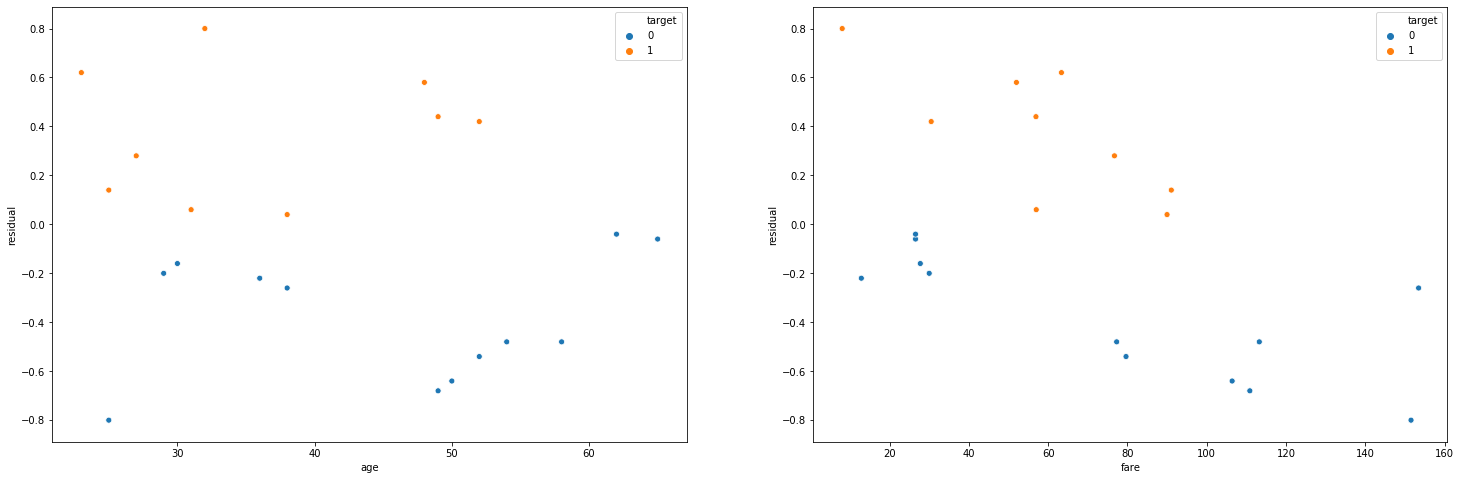

In [31]:
num_rows = int(np.ceil(len(num_cols) / 2))

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(25,num_rows*8))
ax= axes.flatten()
for index,col in enumerate(num_cols,0):
    axes = ax[index]
    sns.scatterplot(mis_classified[col],mis_classified["residual"],hue=mis_classified["target"],ax=axes)

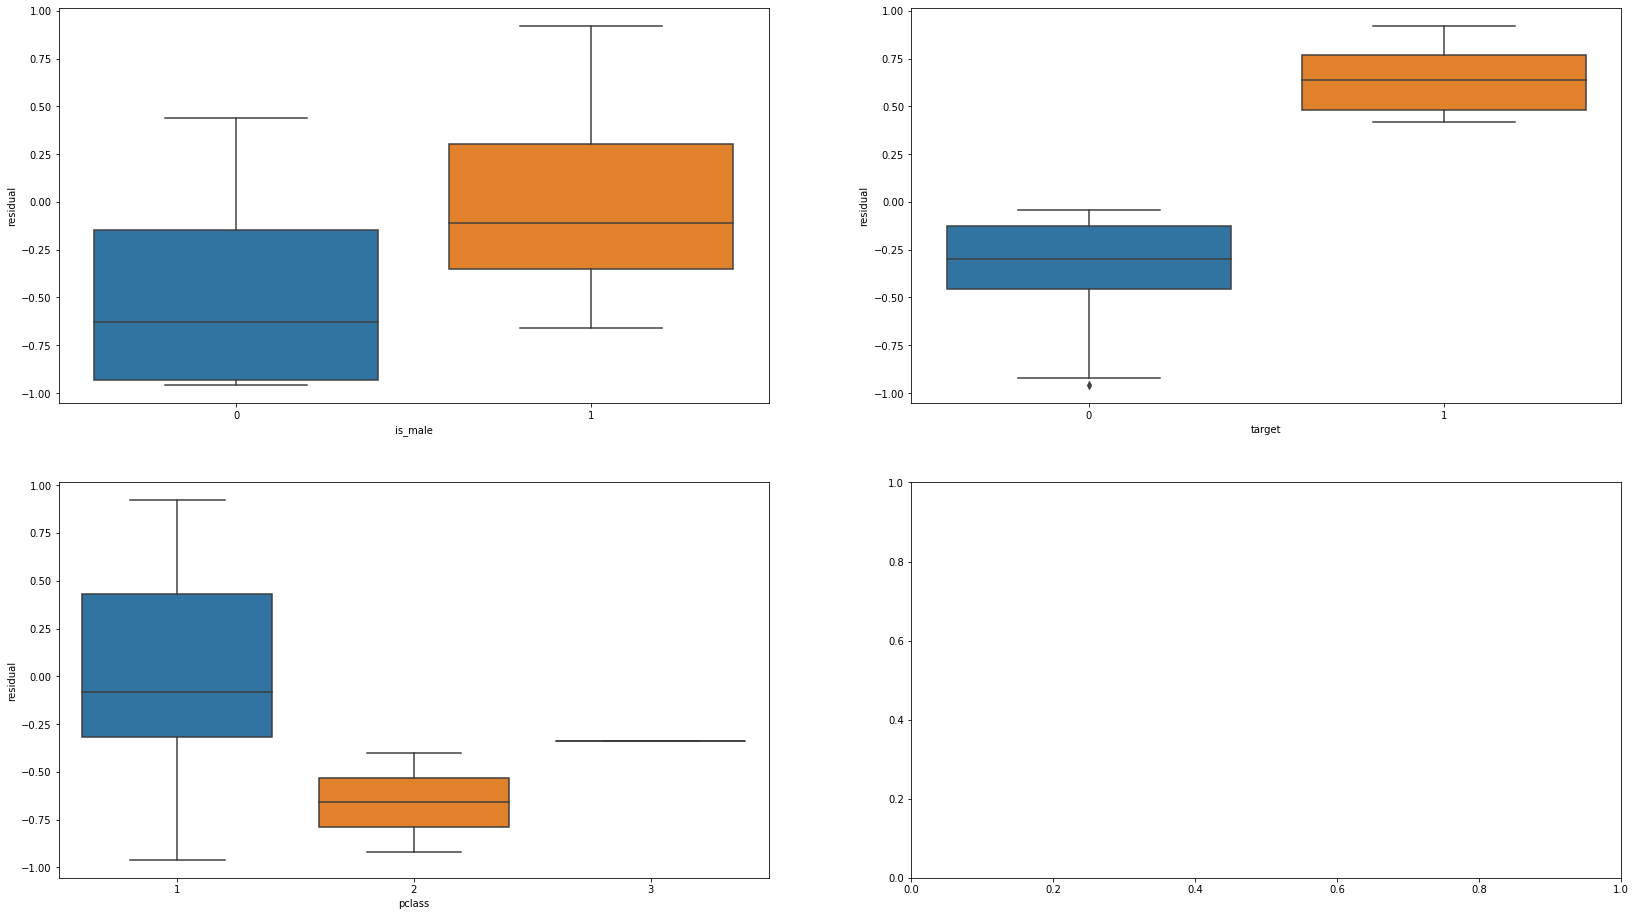

In [174]:
num_rows = int(np.ceil(len(cat_cols) / 2))

fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(28,num_rows*8))
ax= axes.flatten()
for index,col in enumerate(cat_cols,0):
    axes = ax[index]
    sns.boxplot(mis_classified[col],mis_classified["residual"],ax=axes)